# Cosmological structure

How to use `twinLab` to create a surrogate model for the cosmological matter power spectrum, a quantity that can be both measured from observations of galaxy clustering or weak gravitational lensing and also calculated theoretically using $n$-body simulations.

## Configuration

We need to supply our credentials to use `twinLab`.

In [98]:
# Standard imports
import os
import dotenv

In [99]:
# User and group details
USER_NAME = "mead"
GROUP_NAME = "digilab"

# Campaign
CAMPAIGN_ID = "cosmology"

# Data options
POWER_RATIO = True
POWER_LOG = True

# Data files
TRAINING_FILEBASE = "cosmo"
EVALUATION_FILEBASE = "eval"
GRID_DATA = "grid.csv"

# Directories
CAMPAIGN_DIR = "./resources/campaigns/cosmology"
DATASETS_DIR = "./resources/datasets"

In [100]:
ratio_thing = '_ratio' if POWER_RATIO else ''
log_thing = '_log' if POWER_LOG else ''

TRAINING_DATA = TRAINING_FILEBASE+ratio_thing+log_thing+".csv"
EVALUATION_DATA = EVALUATION_FILEBASE+ratio_thing+log_thing+".csv"

# File paths
DATASET_PATH = os.path.join(DATASETS_DIR, TRAINING_DATA)
EVALUATION_PATH = os.path.join(CAMPAIGN_DIR, EVALUATION_DATA)
GRID_PATH = os.path.join(CAMPAIGN_DIR, GRID_DATA)

# Write to screen
print(f"Grid........ {GRID_PATH}")
print(f"Dataset..... {DATASET_PATH}")
print(f"Evaluate.... {EVALUATION_PATH}")

Grid........ ./resources/campaigns/cosmology/grid.csv
Dataset..... ./resources/datasets/cosmo_ratio_log.csv
Evaluate.... ./resources/campaigns/cosmology/eval_ratio_log.csv


Create an `.env` file from `.env.example`, and fill in your `USER_NAME` and `GROUP_NAME`.

In [101]:
!cp .env.example .env

dotenv_file = dotenv.find_dotenv()
_ = dotenv.set_key(dotenv_file, "USER_NAME", USER_NAME)
_ = dotenv.set_key(dotenv_file, "GROUP_NAME", GROUP_NAME)

### Library

Import the `twinLab` client with: 

In [102]:
# Standard imports
from pprint import pprint

# Third-party imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# twinLab
import twinlab as tl

Ensure that the correct group and user names are reported.
These are used to track client usage.

## Run

### Upload dataset

We'll use the csv data in `resources/datasets/cosmology.csv` to train our emulator:

In [103]:
tl.upload_dataset(DATASET_PATH)

**NOTE:** If your dataset is larger than `6mb` you should use `tl.upload_big_dataset(DATASET_PATH)`

### List datasets

Check which datasets are avalible to train with:

In [104]:
datasets = tl.list_datasets()
pprint(datasets)

['basic.csv',
 'big.csv',
 'cosmo.csv',
 'cosmo_log.csv',
 'cosmo_random.csv',
 'cosmo_ratio_log.csv',
 'cosmology.csv',
 'cosmology_latin_small.csv',
 'cosmology_random_small.csv',
 'leaf_spring.csv',
 'ukaea_medium.csv',
 'ukaea_small.csv']


### View dataset statistics

You can query the dataset to provide a statistical summary:

In [105]:
df = tl.query_dataset(TRAINING_DATA)
display(df)

,z,Omega_c,Omega_b,Omega_k,h,ns,sigma_8,w0,wa,m_nu,...,k90,k91,k92,k93,k94,k95,k96,k97,k98,k99
count,100,100.000000,100.000000,100,100.000000,100.000000,100.000000,100,100,100,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0,0.248672,0.045020,0,0.710490,0.959222,0.799503,-1,0,0,...,3.278128,3.349094,3.418124,3.485311,3.550714,3.614370,3.676303,3.736533,3.795075,3.851946
std,0,0.027362,0.005839,0,0.107104,0.029510,0.058187,0,0,0,...,0.152605,0.152013,0.151390,0.150744,0.150094,0.149460,0.148865,0.148330,0.147866,0.147477
min,0,0.200736,0.035432,0,0.504921,0.910543,0.701463,-1,0,0,...,3.026571,3.096469,3.164676,3.231181,3.295978,3.359068,3.420440,3.480051,3.537884,3.593961
25%,0,0.223226,0.040217,0,0.629693,0.931367,0.753887,-1,0,0,...,3.160660,3.230038,3.297582,3.363732,3.428349,3.491501,3.553166,3.612576,3.670600,3.726879
50%,0,0.246814,0.044847,0,0.713631,0.963094,0.799296,-1,0,0,...,3.266778,3.340082,3.410874,3.477698,3.542525,3.605529,3.666886,3.728421,3.788271,3.845227
75%,0,0.270946,0.050221,0,0.805152,0.981608,0.851445,-1,0,0,...,3.395728,3.467558,3.534496,3.599620,3.662295,3.723077,3.782104,3.839471,3.895228,3.952268
max,0,0.297562,0.054848,0,0.894653,1.009910,0.899093,-1,0,0,...,3.639352,3.707385,3.773549,3.837959,3.900703,3.962909,4.023664,4.082772,4.140304,4.196317


### Training

Set the emulator training parameters:

In [106]:
# Set parameters
nk = 100
cosmological_parameters = ["Omega_c", "Omega_b", "h", "ns", "sigma_8"]
wavenumber_columns = [f"k{i}" for i in range(nk)]
params = {
    "filename": TRAINING_DATA,
    "inputs": cosmological_parameters,
    "outputs": wavenumber_columns,
    "decompose_outputs": True,
    "output_explained_variance": 0.9999,
    "train_test_split": 90,
}
pprint(params, compact=True, sort_dicts=False)

{'filename': 'cosmo_ratio_log.csv',
 'inputs': ['Omega_c', 'Omega_b', 'h', 'ns', 'sigma_8'],
 'outputs': ['k0', 'k1', 'k2', 'k3', 'k4', 'k5', 'k6', 'k7', 'k8', 'k9', 'k10',
             'k11', 'k12', 'k13', 'k14', 'k15', 'k16', 'k17', 'k18', 'k19',
             'k20', 'k21', 'k22', 'k23', 'k24', 'k25', 'k26', 'k27', 'k28',
             'k29', 'k30', 'k31', 'k32', 'k33', 'k34', 'k35', 'k36', 'k37',
             'k38', 'k39', 'k40', 'k41', 'k42', 'k43', 'k44', 'k45', 'k46',
             'k47', 'k48', 'k49', 'k50', 'k51', 'k52', 'k53', 'k54', 'k55',
             'k56', 'k57', 'k58', 'k59', 'k60', 'k61', 'k62', 'k63', 'k64',
             'k65', 'k66', 'k67', 'k68', 'k69', 'k70', 'k71', 'k72', 'k73',
             'k74', 'k75', 'k76', 'k77', 'k78', 'k79', 'k80', 'k81', 'k82',
             'k83', 'k84', 'k85', 'k86', 'k87', 'k88', 'k89', 'k90', 'k91',
             'k92', 'k93', 'k94', 'k95', 'k96', 'k97', 'k98', 'k99'],
 'decompose_outputs': True,
 'output_explained_variance': 0.9999,
 'train

Train the emulator:

In [107]:
tl.train_campaign(params, CAMPAIGN_ID)

Check which campaigns are ready with:

In [108]:
campaigns = tl.list_campaigns()
pprint(campaigns)

['ukaea', 'cosmology']


View the metadata of an emulator with:

In [109]:
query = tl.query_campaign(CAMPAIGN_ID)
pprint(query, compact=True)

{'calibration_error': 0.23489753229171625,
 'diagnostics': {'estimator_diagnostics': {'base_estimator_diagnostics': {'covar_module.base_kernel.lengthscale_prior.concentration': 3.0,
                                                                          'covar_module.base_kernel.lengthscale_prior.rate': 6.0,
                                                                          'covar_module.base_kernel.raw_lengthscale': [[[2.197074315817402,
                                                                                                                         4.082255988481643,
                                                                                                                         2.381803835038007,
                                                                                                                         2.8997858615181342,
                                                                                                                         2.9420

### Sample

Sample the trained emulator with:

In [110]:
df_eval_mean, df_eval_std = tl.sample_campaign(EVALUATION_PATH, CAMPAIGN_ID)
df_train_mean, df_train_std = tl.sample_campaign(DATASET_PATH, CAMPAIGN_ID)

Read in the evaluation data and the grid of $k$ values on which to evaluate $P(k)$

In [111]:
df_train = pd.read_csv(DATASET_PATH)
df_grid = pd.read_csv(GRID_PATH)
df_eval = pd.read_csv(EVALUATION_PATH)

In [112]:
# Accuracy statistics
# accuracy = df_eval_mean[wavenumber_columns]-df_eval[wavenumber_columns]
accuracy = 100.*np.sqrt(((df_eval_mean[wavenumber_columns]-df_eval[wavenumber_columns])**2).mean())
# accuracy = (df_eval_mean[wavenumber_columns]-df_eval[wavenumber_columns]).std()
# accuracy = (-1.+(df_eval_mean[wavenumber_columns]/df_eval[wavenumber_columns])).mean()
display(accuracy)

k0     0.000006
k1     0.000008
k2     0.000010
k3     0.000012
k4     0.000015
         ...   
k95    0.211116
k96    0.222847
k97    0.238652
k98    0.257964
k99    0.280499
Length: 100, dtype: float64

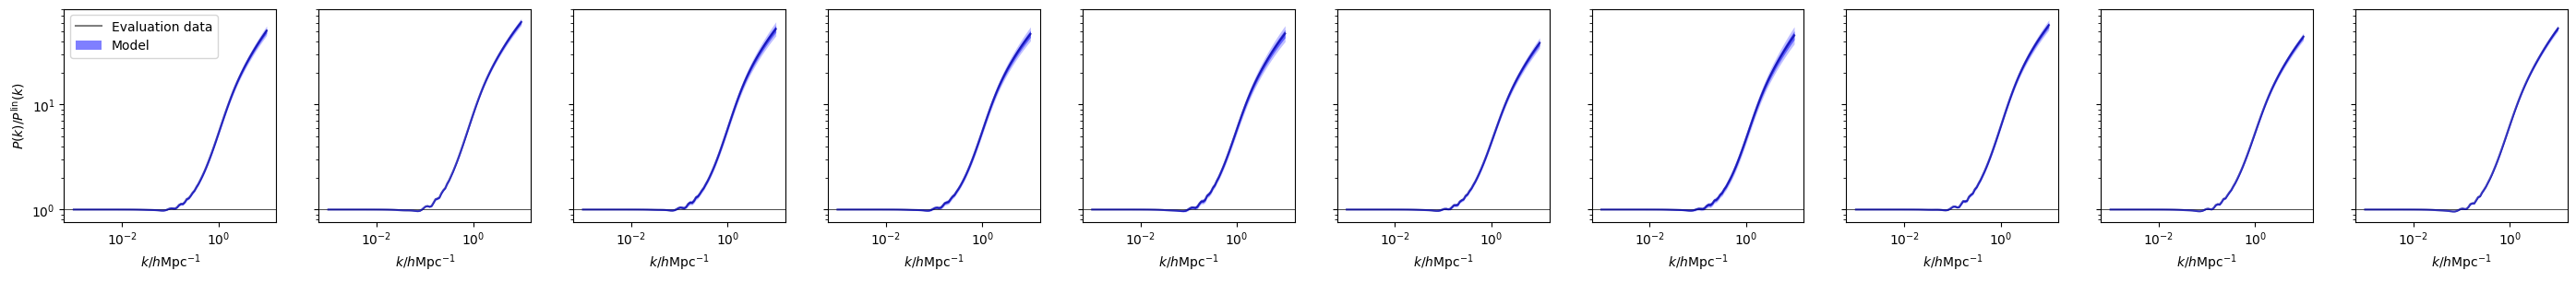

In [118]:
# Plotting parameters
nsig = [1, 2]       # sigma errors to plot
mfac = 10.         # Factor to inflate error bars by
alpha_data = 0.5
alpha_model = 0.5
color_model = "blue"
plot_band = True
plot_mean = True
npow = 10

# Plot power
plt.subplots(1, npow, figsize=(35., 3.), sharex=True, sharey=True)
grid = df_grid.iloc[0].values
for i in range(npow):
    plt.subplot(1, npow, i+1)
    if POWER_RATIO:
        plt.axhline(1., color="black", lw=0.5)
    eval = df_eval[wavenumber_columns].iloc[i].values
    mean = df_eval_mean.iloc[i].values
    err = df_eval_std.iloc[i].values
    if POWER_LOG:
        eval, mean = np.exp(eval), np.exp(mean)
    label = "Evaluation data" if i==0 else None
    plt.plot(grid, eval, color="black", alpha=alpha_data, label=label)
    if plot_band:
        for sig in nsig:
            if POWER_LOG:
                ymin, ymax = np.exp(-mfac*sig*err), np.exp(mfac*sig*err)
                ymin, ymax = mean*ymin, mean*ymax
            else:
                ymin, ymax = -mfac*sig*err, mfac*sig*err
                ymin, ymax = mean+ymin, mean+ymax
            label = "Model" if sig==nsig[0] else None
            plt.fill_between(grid, ymin, ymax, color=color_model, lw=0., alpha=alpha_model/sig, label=label)
    if plot_mean:
        label  = "Model" if not plot_band else None
        plt.plot(grid, mean, color=color_model, alpha=alpha_model, label=label)
    plt.xlabel(r"$k/h\mathrm{Mpc}^{-1}$")
    plt.xscale("log")
    if i==0: 
        if POWER_RATIO:
            plt.ylabel(r"$P(k)/P^\mathrm{lin}(k)$")
        else:
            plt.ylabel(r"$P(k)/(h^{-1}\mathrm{Mpc})^3$")
        plt.legend()
    plt.yscale("log")
plt.show()

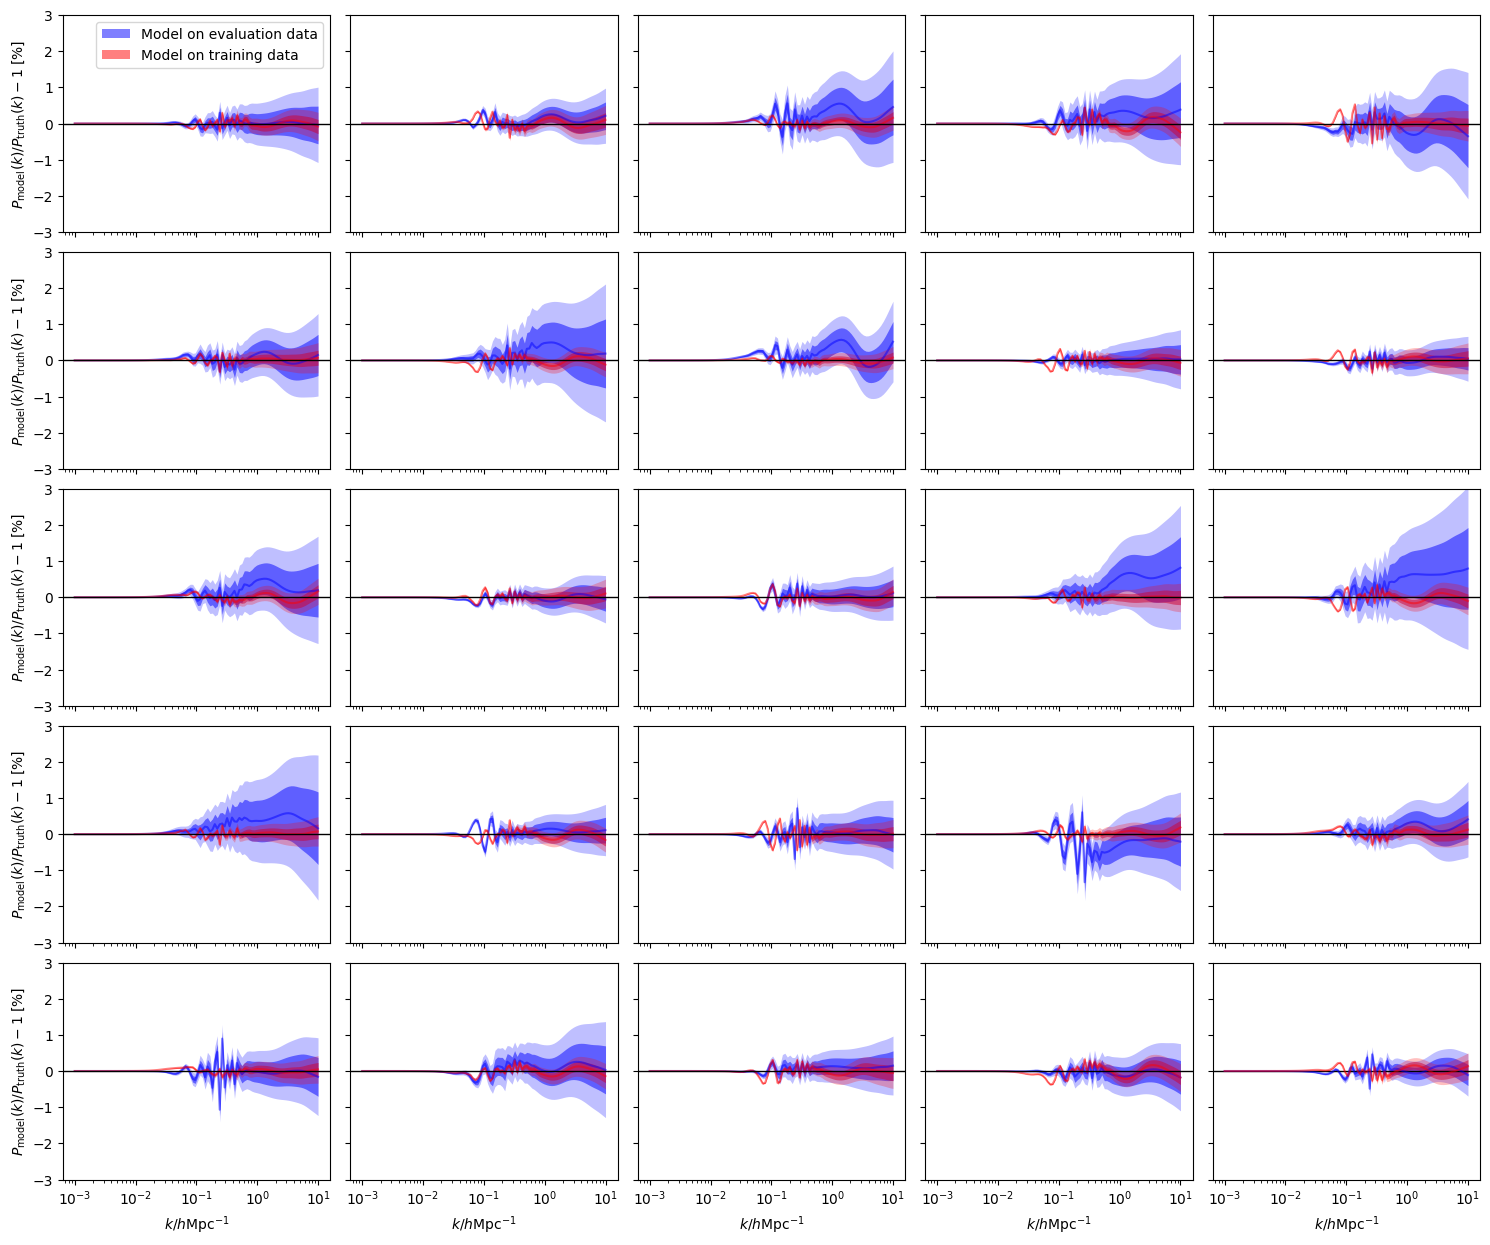

In [122]:
# Parameters
nsig = [1, 2]
alpha_data = 0.5
alpha_model = 0.5
color_model = "blue"
plot_train = True
alpha_train = 0.5
color_train = "red"
dr = 3.
plot_band = True
plot_mean = True
ncos = 25
nrow = 5

# Calculations
ncol = ncos//nrow

# Plot
grid = df_grid.iloc[0].values
plt.subplots(nrow, ncol, figsize=(3*ncol, 2.5*nrow), sharex=True, sharey=True)
for i in range(ncos):
    plt.axhline(0., color="black", lw=1)
    plt.subplot(nrow, ncol, i+1)
    eval = df_eval[wavenumber_columns].iloc[i].values
    eval_mean = df_eval_mean.iloc[i].values
    eval_err = df_eval_std.iloc[i].values
    train = df_train[wavenumber_columns].iloc[i].values
    train_mean = df_train_mean.iloc[i].values
    train_err = df_train_std.iloc[i].values
    if POWER_LOG:
        eval, eval_mean = np.exp(eval), np.exp(eval_mean)
        train, train_mean = np.exp(train), np.exp(train_mean)
    if plot_band:
        for sig in nsig:
            if POWER_LOG:
                ymin, ymax = np.exp(-sig*eval_err), np.exp(sig*eval_err)
                ymin, ymax = 100.*((eval_mean*ymin)/eval-1.), 100.*((eval_mean*ymax)/eval-1.)
            else:
                ymin, ymax = -sig*eval_err, sig*eval_err
                ymin, ymax = 100.*((eval_mean+ymin)/eval-1.), 100.*((eval_mean+ymax)/eval-1.)
            label = "Model on evaluation data" if sig==nsig[0] else None
            plt.fill_between(grid, ymin, ymax, color=color_model, lw=0, alpha=alpha_model/sig, label=label)
            if plot_train:
                if POWER_LOG:
                    ymin, ymax = np.exp(-sig*train_err), np.exp(sig*train_err)
                    ymin, ymax = 100.*((train_mean*ymin)/train-1.), 100.*((train_mean*ymax)/train-1.)
                else:
                    ymin, ymax = -sig*train_err, sig*train_err
                    ymin, ymax = 100.*((train_mean+ymin)/train-1.), 100.*((train_mean+ymax)/train-1.)
                label = "Model on training data" if sig==nsig[0] else None
                plt.fill_between(grid, ymin, ymax, color=color_train, lw=0, alpha=alpha_train/sig, label=label)
    if plot_mean:
        label = "Model on evaluation data" if not plot_band else None
        y = 100.*(eval_mean/eval-1.)
        plt.plot(grid, y, color=color_model, alpha=alpha_model, label=label)
        if plot_train:
            label = "Model on training data" if not plot_band else None
            y = 100.*(train_mean/train-1.)
            plt.plot(grid, y, color=color_train, alpha=alpha_train, label=label)
    if i//ncol==nrow-1: plt.xlabel(r"$k/h\mathrm{Mpc}^{-1}$")
    plt.xscale("log")
    if i%ncol==0: plt.ylabel(r"$P_\mathrm{model}(k)/P_\mathrm{truth}(k)-1$ [%]")
    plt.ylim((-dr, dr))
    if i==0: plt.legend()
plt.tight_layout()
plt.show()

### Delete emulator

Delete a trained emulator with:

In [115]:
# tl.delete_campaign(CAMPAIGN_ID)

### Delete dataset

Delete an existing dataset with:

In [116]:
# tl.delete_dataset(TRAINING_DATA)